[saved] table → output/neuron_diff_tabe/table_layer1_fc1.csv  (rows=4096, cols=49)


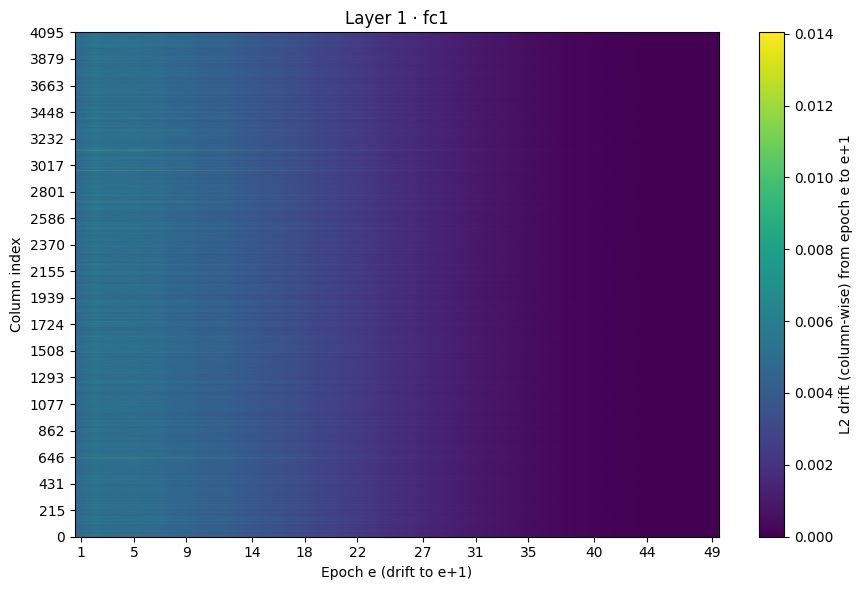

[saved] table → output/neuron_diff_tabe/table_layer1_fc2.csv  (rows=16384, cols=49)


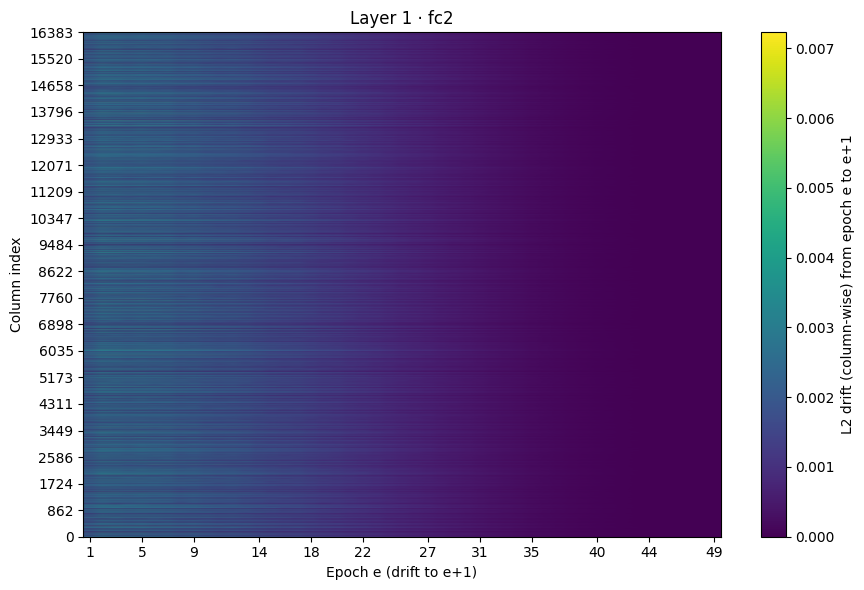

[saved] table → output/neuron_diff_tabe/table_layer1_final_layer_norm.csv  (rows=4096, cols=49)


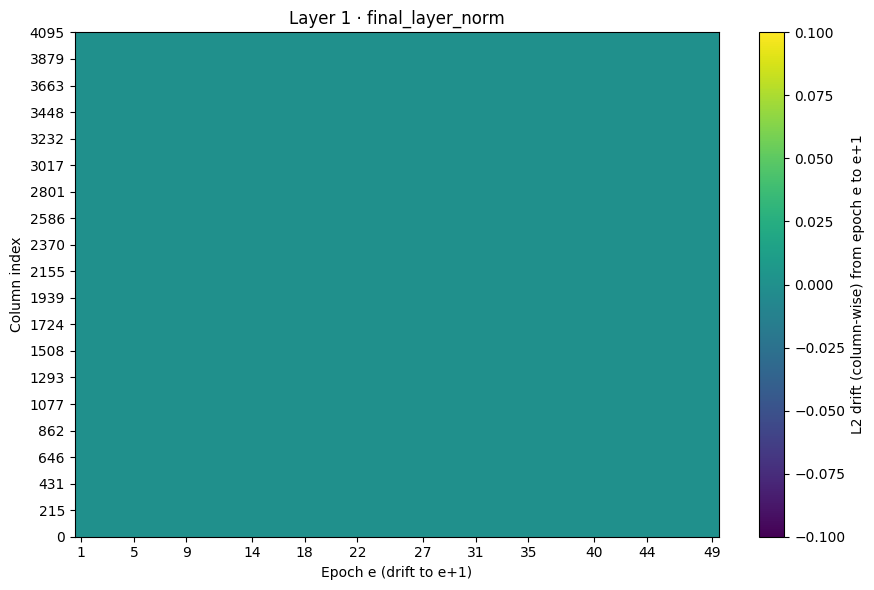

[saved] table → output/neuron_diff_tabe/table_layer1_k_proj.csv  (rows=4096, cols=49)


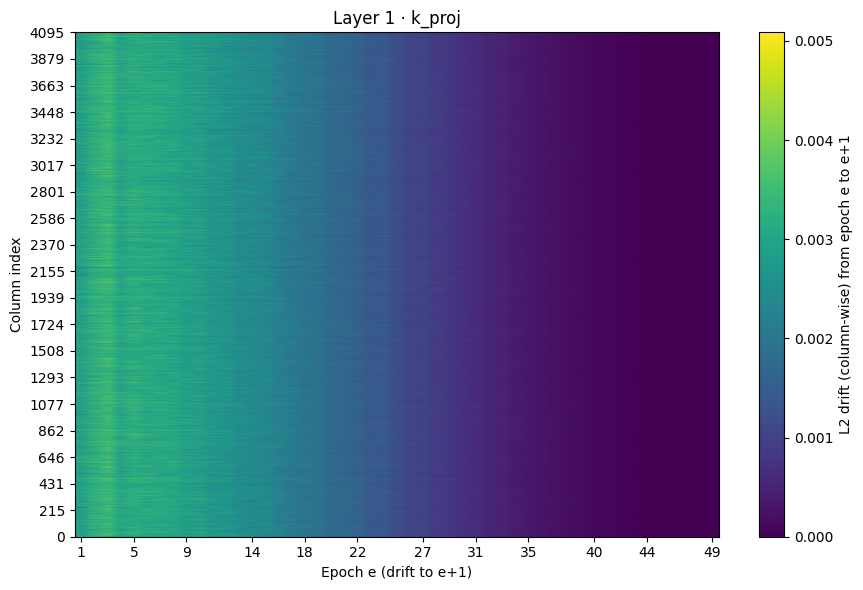

[saved] table → output/neuron_diff_tabe/table_layer1_out_proj.csv  (rows=4096, cols=49)


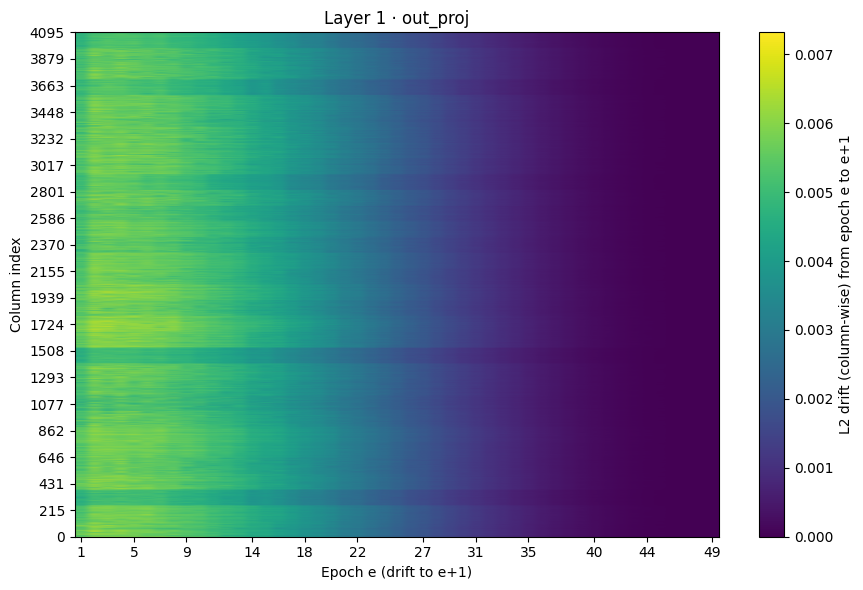

[saved] table → output/neuron_diff_tabe/table_layer1_q_proj.csv  (rows=4096, cols=49)


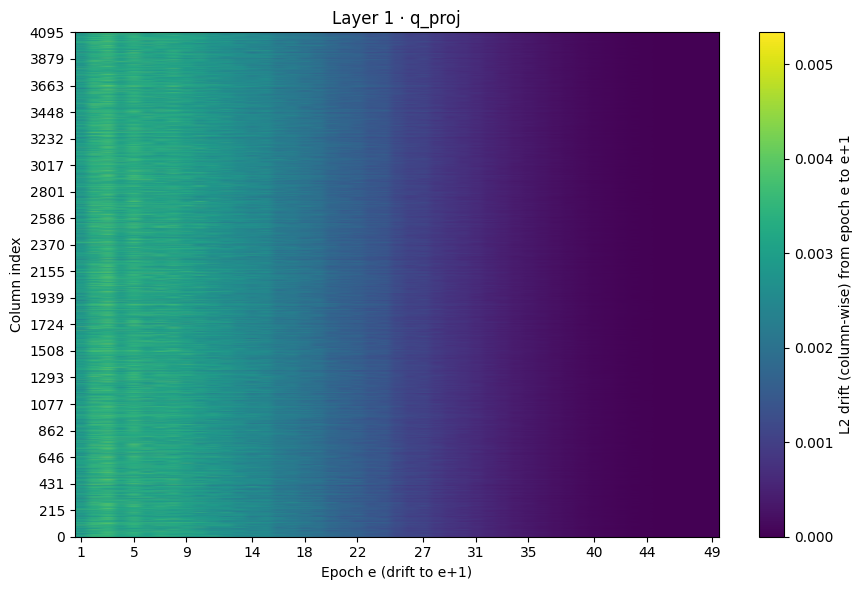

[saved] table → output/neuron_diff_tabe/table_layer1_self_attn_layer_norm.csv  (rows=4096, cols=49)


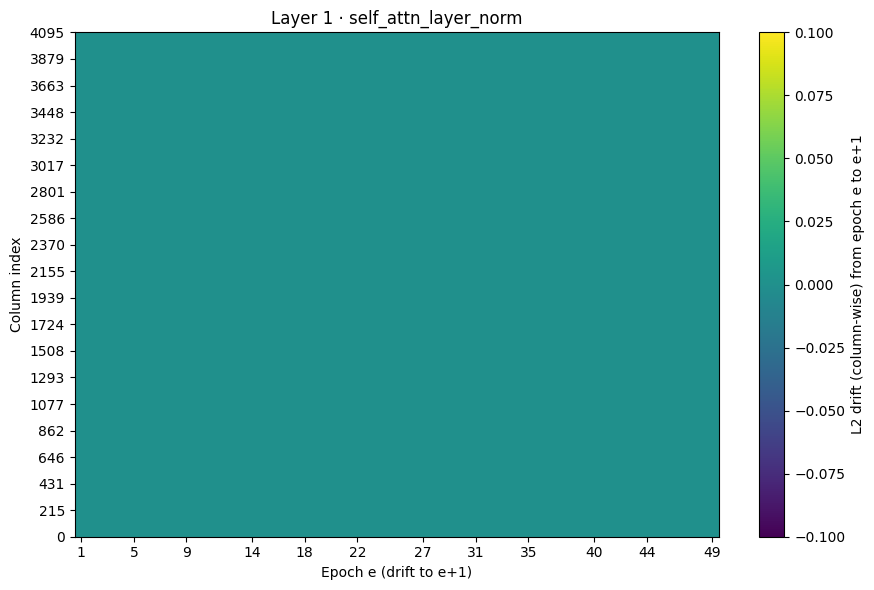

[saved] table → output/neuron_diff_tabe/table_layer1_v_proj.csv  (rows=4096, cols=49)


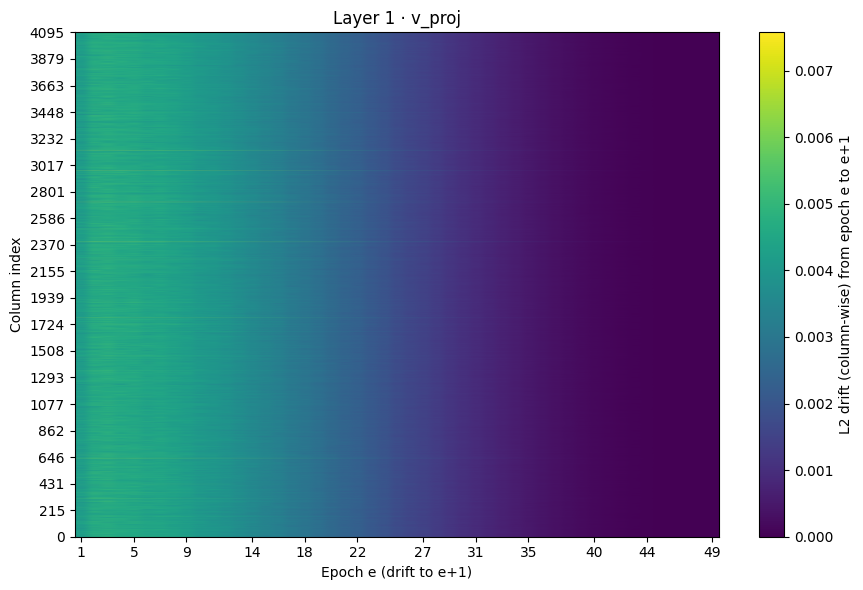

In [9]:
#!/usr/bin/env python3
# plot_drift_heatmaps.py
import argparse, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def build_pivot(df_op: pd.DataFrame) -> tuple[pd.DataFrame, np.ndarray]:
    """
    Return (P, epochs) where P is a pivot table:
      index=row = column index (or LN element id)
      columns = epoch_from (drift from e -> e+1)
      values  = l2_abs_change
    """
    df_op = df_op.copy()
    df_op["epoch_from"] = df_op["epoch_from"].astype(int)
    df_op["index"] = df_op["index"].astype(int)
    P = (df_op.pivot(index="index", columns="epoch_from", values="l2_abs_change")
                .sort_index(axis=0)
                .sort_index(axis=1))
    epochs = P.columns.to_numpy()
    return P, epochs

def autoscale_ticks(ax, values, axis="x", max_ticks=12):
    n = len(values)
    if n <= max_ticks:
        ticks = np.arange(n)
    else:
        ticks = np.linspace(0, n - 1, max_ticks, dtype=int)
        ticks = np.unique(ticks)
    labels = [str(values[i]) for i in ticks]
    if axis == "x":
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels, rotation=0)
    else:
        ax.set_yticks(ticks)
        ax.set_yticklabels(labels)

layer = 1
input_file = "test.csv"
outdir = 'output/neuron_diff_tabe'
os.makedirs(outdir, exist_ok=True)
# tables_dir = args.tables_outdir or args.outdir
os.makedirs(outdir, exist_ok=True)

df = pd.read_csv(input_file)
df = df[df["layer"] == layer].copy()
if df.empty:
    raise SystemExit(f"No rows for layer {layer} in {input_file}")

# Limit to requested operators if provided
# if args.ops:
#     ops = [s.strip() for s in args.ops.split(",") if s.strip()]
#     df = df[df["operator"].isin(ops)]
#     if df.empty:
#         raise SystemExit("After filtering by --ops, no data remains.")
# else:
ops = sorted(df["operator"].unique())

# Parse preview size if requested
# preview_rows = preview_cols = None
# if args.preview:
#     try:
#         r, c = args.preview.lower().split("x")
#         preview_rows, preview_cols = int(r), int(c)
#     except Exception:
#         raise SystemExit("--preview must look like '10x8' (ROWSxCOLS)")

for op in ops:
    df_op = df[df["operator"] == op]
    if df_op.empty:
        print(f"[skip] No rows for operator={op}")
        continue

    # Build pivot table and save it
    P, epochs = build_pivot(df_op)
    table_path = os.path.join(outdir, f"table_layer{layer}_{op}.csv")
    P.to_csv(table_path, float_format="%.6g")
    print(f"[saved] table → {table_path}  (rows={P.shape[0]}, cols={P.shape[1]})")

    # # Optional: print a small preview
    # if preview_rows and preview_cols:
    #     print(f"\n# Preview: {op} (first {preview_rows} rows × {preview_cols} cols)")
    #     print(P.iloc[:preview_rows, :preview_cols])

    # Plot heatmap
    M = P.to_numpy(dtype=np.float32)
    M_masked = np.ma.masked_invalid(M)

    fig = plt.figure(figsize=(9, 6))
    ax = plt.gca()
    im = ax.imshow(M_masked, origin="lower", aspect="auto")  # no custom colors
    cbar = plt.colorbar(im)
    cbar.set_label("L2 drift (column-wise) from epoch e to e+1")

    ax.set_xlabel("Epoch e (drift to e+1)")
    ax.set_ylabel("Column index")

    autoscale_ticks(ax, epochs, axis="x", max_ticks=12)
    autoscale_ticks(ax, np.arange(M.shape[0]), axis="y", max_ticks=20)

    title = f"Layer {layer} · {op}"
    ax.set_title(title)

    # png_path = os.path.join(args.outdir, f"heatmap_layer{layer}_{op}.png")
    plt.tight_layout()
    # plt.savefig(png_path, dpi=150)
    plt.show()
    plt.close(fig)
    # print(f"[saved] heatmap → {png_path}")
